In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd

class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()
        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.out = nn.Linear(h1_nodes, out_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

class FrozenLakeDQL():
    learning_rate_a = 0.001
    discount_factor_g = 0.9
    network_sync_rate = 10
    replay_memory_size = 1000
    mini_batch_size = 32
    loss_fn = nn.MSELoss()
    optimizer = None
    ACTIONS = ['L', 'D', 'R', 'U']

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        epsilon = 1
        memory = ReplayMemory(self.replay_memory_size)

        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        rewards_per_episode = np.zeros(episodes)
        epsilon_history = []
        step_count = 0
            
        for i in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False    

            while not terminated and not truncated:
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                new_state, reward, terminated, truncated, _ = env.step(action)
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                step_count += 1

            if reward == 1:
                rewards_per_episode[i] = 1

            if len(memory) > self.mini_batch_size and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)        

                epsilon = max(epsilon - 1 / episodes, 0)
                epsilon_history.append(epsilon)

                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0

        env.close()
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")

        self.plot_results(rewards_per_episode, epsilon_history, episodes)

    def optimize(self, mini_batch, policy_dqn, target_dqn):
        
        
        
        num_states = policy_dqn.fc1.in_features
        current_q_list = []
        target_q_list = []

        
        
        for state, action, new_state, reward, terminated in mini_batch:
            if terminated: 
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            target_q = target_dqn(self.state_to_dqn_input(state, num_states)) 
            target_q[action] = target
            target_q_list.append(target_q)
            
            
            
                
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def state_to_dqn_input(self, state, num_states):
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    def test(self, episodes, is_slippery=False):
        
        
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        
        
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions) 
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()

        for i in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False            

            while not terminated and not truncated:  
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()
                state, reward, terminated, truncated, _ = env.step(action)

        env.close()

    def plot_results(self, rewards_per_episode, epsilon_history, episodes):
        plt.figure(figsize=(12, 5))

       
        window_size = 50
        rewards_smoothed = pd.Series(rewards_per_episode).rolling(window=window_size).mean()

        
        plt.subplot(1, 2, 1)
        plt.plot(rewards_smoothed, color='b', label='Avg Reward (Moving Avg)')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title('Rewards over Episodes')
        plt.legend()
        plt.grid(True)

        
        plt.subplot(1, 2, 2)
        plt.plot(epsilon_history, color='r', linestyle='--', marker='o', markersize=3, label='Epsilon')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon Value')
        plt.title('Epsilon Decay over Episodes')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('frozen_lake_dql_improved.png')
        plt.show()



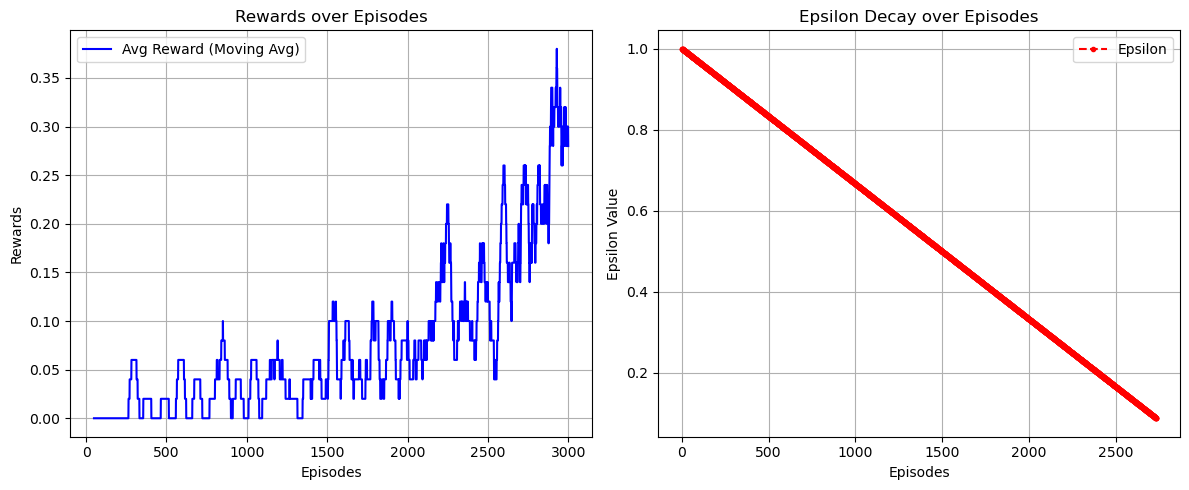

C:\Users\maraw\AppData\Local\Temp\ipykernel_35136\488047328.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt")

In [17]:
if __name__ == '__main__':

    frozen_lake = FrozenLakeDQL()
    is_slippery = True
    frozen_lake.train(3000, is_slippery=is_slippery)
    frozen_lake.test(5, is_slippery=is_slippery)

In [2]:
if __name__ == '__main__':

    frozen_lake = FrozenLakeDQL()
    is_slippery = True
    frozen_lake.test(5, is_slippery=is_slippery)

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd

class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()
        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.out = nn.Linear(h1_nodes, out_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

class FrozenLakeDQL1():
    learning_rate_a = 0.001
    discount_factor_g = 0.9
    network_sync_rate = 10
    replay_memory_size = 1000
    mini_batch_size = 32
    loss_fn = nn.MSELoss()
    optimizer = None
    ACTIONS = ['L', 'D', 'R', 'U']

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        epsilon = 1
        memory = ReplayMemory(self.replay_memory_size)

        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        rewards_per_episode = np.zeros(episodes)
        epsilon_history = []
        step_count = 0

        for i in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False    
            episode_reward = 0  

            while not terminated and not truncated:
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                new_state, reward, terminated, truncated, _ = env.step(action)
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                step_count += 1
                episode_reward += reward  

            rewards_per_episode[i] = episode_reward
            print(f"Episode {i+1}: Reward = {episode_reward}")

            if len(memory) > self.mini_batch_size and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)        

                epsilon = max(epsilon - 1 / episodes, 0)
                epsilon_history.append(epsilon)

                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0

        env.close()
        torch.save(policy_dqn.state_dict(), "frozen1_lake_dql.pt")

        self.plot_results(rewards_per_episode, epsilon_history, episodes)

    def optimize(self, mini_batch, policy_dqn, target_dqn):
        num_states = policy_dqn.fc1.in_features
        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated: 
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            target_q = target_dqn(self.state_to_dqn_input(state, num_states)) 
            target_q[action] = target
            target_q_list.append(target_q)

        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def state_to_dqn_input(self, state, num_states):
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    def test(self, episodes, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions) 
        policy_dqn.load_state_dict(torch.load("frozen1_lake_dql.pt"))
        policy_dqn.eval()

        for i in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False            

            while not terminated and not truncated:  
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()
                state, reward, terminated, truncated, _ = env.step(action)

        env.close()

    def plot_results(self, rewards_per_episode, epsilon_history, episodes):
        plt.figure(figsize=(12, 5))

        window_size = 50
        rewards_smoothed = pd.Series(rewards_per_episode).rolling(window=window_size).mean()

        plt.subplot(1, 2, 1)
        plt.plot(rewards_smoothed, color='b', label='Avg Reward (Moving Avg)')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title('Rewards over Episodes')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epsilon_history, color='r', linestyle='--', marker='o', markersize=3, label='Epsilon')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon Value')
        plt.title('Epsilon Decay over Episodes')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('frozen1_lake_dql_improved.png')
        plt.show()

    def show_q_table(self, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery)
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load("frozen1_lake_dql.pt"))
        policy_dqn.eval()

        print("\nQ-table (approximated by the neural network):")
        for state in range(num_states):
            with torch.no_grad():
                q_values = policy_dqn(self.state_to_dqn_input(state, num_states)).numpy()
            print(f"State {state}: {q_values}")

        env.close()


Episode 1: Reward = 0.0
Episode 2: Reward = 0.0
Episode 3: Reward = 0.0
Episode 4: Reward = 0.0
Episode 5: Reward = 0.0
Episode 6: Reward = 0.0
Episode 7: Reward = 0.0
Episode 8: Reward = 0.0
Episode 9: Reward = 0.0
Episode 10: Reward = 0.0
Episode 11: Reward = 0.0
Episode 12: Reward = 0.0
Episode 13: Reward = 0.0
Episode 14: Reward = 0.0
Episode 15: Reward = 0.0
Episode 16: Reward = 0.0
Episode 17: Reward = 0.0
Episode 18: Reward = 0.0
Episode 19: Reward = 0.0
Episode 20: Reward = 0.0
Episode 21: Reward = 0.0
Episode 22: Reward = 0.0
Episode 23: Reward = 0.0
Episode 24: Reward = 0.0
Episode 25: Reward = 0.0
Episode 26: Reward = 0.0
Episode 27: Reward = 0.0
Episode 28: Reward = 0.0
Episode 29: Reward = 0.0
Episode 30: Reward = 0.0
Episode 31: Reward = 0.0
Episode 32: Reward = 0.0
Episode 33: Reward = 0.0
Episode 34: Reward = 0.0
Episode 35: Reward = 0.0
Episode 36: Reward = 0.0
Episode 37: Reward = 0.0
Episode 38: Reward = 0.0
Episode 39: Reward = 0.0
Episode 40: Reward = 0.0
Episode 4

Episode 322: Reward = 0.0
Episode 323: Reward = 0.0
Episode 324: Reward = 0.0
Episode 325: Reward = 0.0
Episode 326: Reward = 0.0
Episode 327: Reward = 0.0
Episode 328: Reward = 0.0
Episode 329: Reward = 0.0
Episode 330: Reward = 0.0
Episode 331: Reward = 0.0
Episode 332: Reward = 0.0
Episode 333: Reward = 0.0
Episode 334: Reward = 0.0
Episode 335: Reward = 0.0
Episode 336: Reward = 0.0
Episode 337: Reward = 0.0
Episode 338: Reward = 0.0
Episode 339: Reward = 0.0
Episode 340: Reward = 0.0
Episode 341: Reward = 0.0
Episode 342: Reward = 0.0
Episode 343: Reward = 0.0
Episode 344: Reward = 0.0
Episode 345: Reward = 0.0
Episode 346: Reward = 0.0
Episode 347: Reward = 0.0
Episode 348: Reward = 0.0
Episode 349: Reward = 0.0
Episode 350: Reward = 0.0
Episode 351: Reward = 0.0
Episode 352: Reward = 0.0
Episode 353: Reward = 0.0
Episode 354: Reward = 0.0
Episode 355: Reward = 0.0
Episode 356: Reward = 0.0
Episode 357: Reward = 0.0
Episode 358: Reward = 0.0
Episode 359: Reward = 0.0
Episode 360:

Episode 641: Reward = 0.0
Episode 642: Reward = 0.0
Episode 643: Reward = 0.0
Episode 644: Reward = 0.0
Episode 645: Reward = 0.0
Episode 646: Reward = 0.0
Episode 647: Reward = 0.0
Episode 648: Reward = 0.0
Episode 649: Reward = 0.0
Episode 650: Reward = 0.0
Episode 651: Reward = 1.0
Episode 652: Reward = 0.0
Episode 653: Reward = 1.0
Episode 654: Reward = 0.0
Episode 655: Reward = 0.0
Episode 656: Reward = 0.0
Episode 657: Reward = 0.0
Episode 658: Reward = 0.0
Episode 659: Reward = 0.0
Episode 660: Reward = 0.0
Episode 661: Reward = 0.0
Episode 662: Reward = 1.0
Episode 663: Reward = 0.0
Episode 664: Reward = 1.0
Episode 665: Reward = 1.0
Episode 666: Reward = 0.0
Episode 667: Reward = 0.0
Episode 668: Reward = 1.0
Episode 669: Reward = 0.0
Episode 670: Reward = 0.0
Episode 671: Reward = 0.0
Episode 672: Reward = 0.0
Episode 673: Reward = 0.0
Episode 674: Reward = 0.0
Episode 675: Reward = 1.0
Episode 676: Reward = 0.0
Episode 677: Reward = 0.0
Episode 678: Reward = 1.0
Episode 679:

Episode 961: Reward = 0.0
Episode 962: Reward = 1.0
Episode 963: Reward = 1.0
Episode 964: Reward = 1.0
Episode 965: Reward = 0.0
Episode 966: Reward = 1.0
Episode 967: Reward = 1.0
Episode 968: Reward = 1.0
Episode 969: Reward = 1.0
Episode 970: Reward = 1.0
Episode 971: Reward = 1.0
Episode 972: Reward = 1.0
Episode 973: Reward = 1.0
Episode 974: Reward = 1.0
Episode 975: Reward = 1.0
Episode 976: Reward = 1.0
Episode 977: Reward = 1.0
Episode 978: Reward = 0.0
Episode 979: Reward = 1.0
Episode 980: Reward = 1.0
Episode 981: Reward = 1.0
Episode 982: Reward = 1.0
Episode 983: Reward = 0.0
Episode 984: Reward = 0.0
Episode 985: Reward = 1.0
Episode 986: Reward = 0.0
Episode 987: Reward = 1.0
Episode 988: Reward = 1.0
Episode 989: Reward = 1.0
Episode 990: Reward = 1.0
Episode 991: Reward = 1.0
Episode 992: Reward = 1.0
Episode 993: Reward = 0.0
Episode 994: Reward = 1.0
Episode 995: Reward = 1.0
Episode 996: Reward = 1.0
Episode 997: Reward = 1.0
Episode 998: Reward = 1.0
Episode 999:

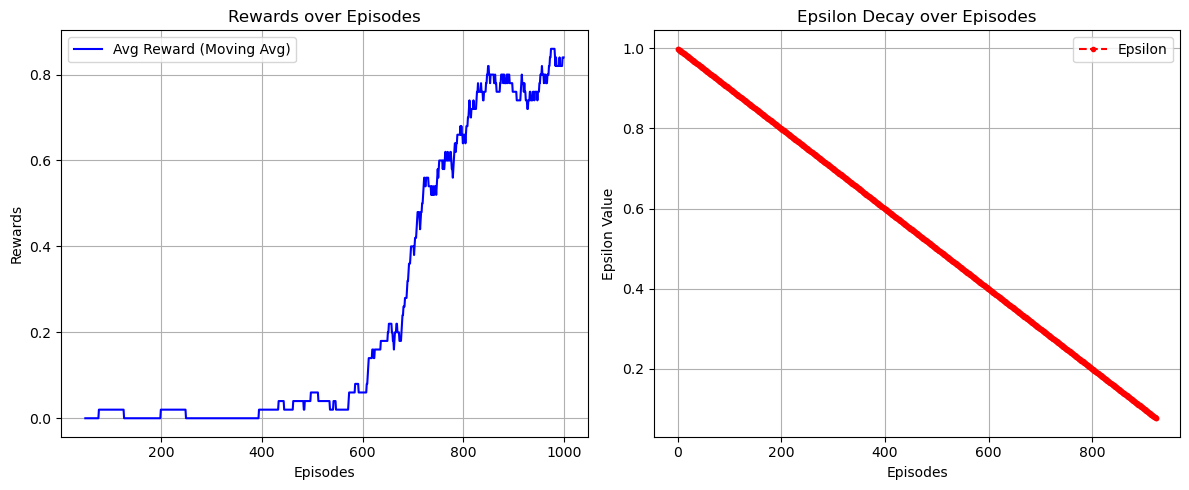

C:\Users\maraw\AppData\Local\Temp\ipykernel_19036\1102204124.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_dqn.load_state_dict(torch.load("frozen1_lake_dql.pt

In [2]:
if __name__ == '__main__':

    frozen_lake = FrozenLakeDQL1()
    is_slippery = False
    frozen_lake.train(1000, is_slippery=is_slippery)
    frozen_lake.test(5, is_slippery=is_slippery)

In [4]:
if __name__ == '__main__':

    frozen_lake = FrozenLakeDQL1()
    is_slippery = False

    frozen_lake.test(5, is_slippery=is_slippery)